In [ ]:
pip install pycoingecko python-dotenv flipside


Summary Statistics:
            lvr      net_lvr  eth_amount  uniswap_price  coinbase_price  \
3     95.374503    95.374503    2.711043        2466.25         2501.43   
5     28.584148    28.584148    0.812511        2466.25         2501.43   
7   7093.470236  7093.470235  201.633605        2466.25         2501.43   
10   124.176689   124.176689    3.529752        2466.25         2501.43   
11    89.536228    89.536228    2.545089        2466.25         2501.43   

        gas_cost  
3   1.004275e-09  
5   8.107322e-09  
7   1.946649e-07  
10  4.264900e-10  
11  1.039446e-09  


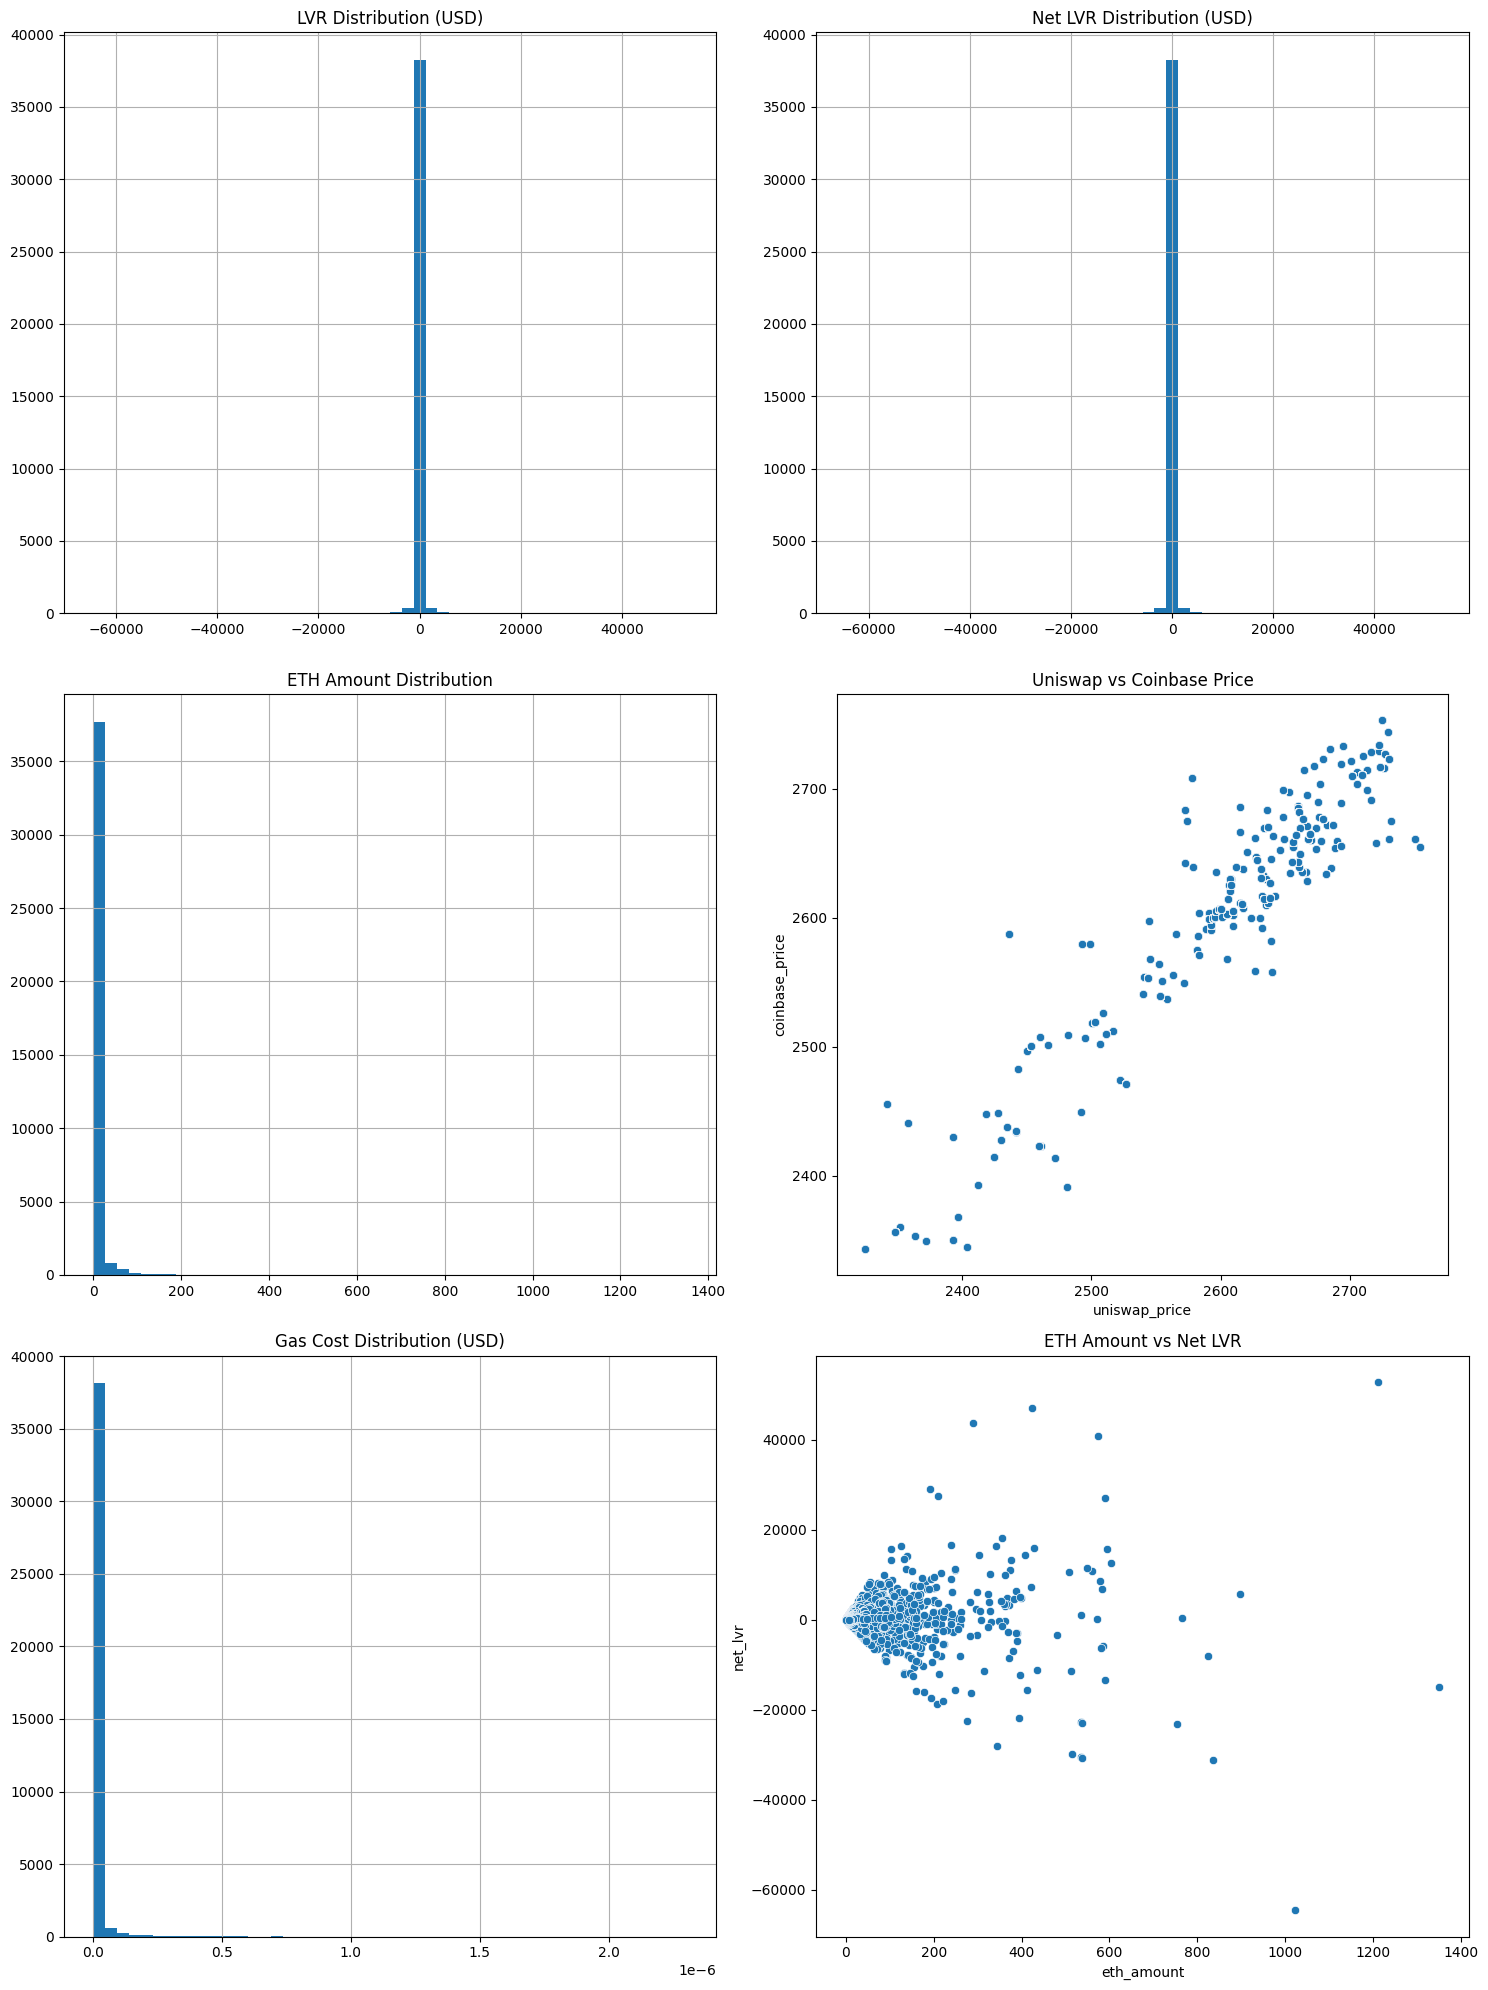

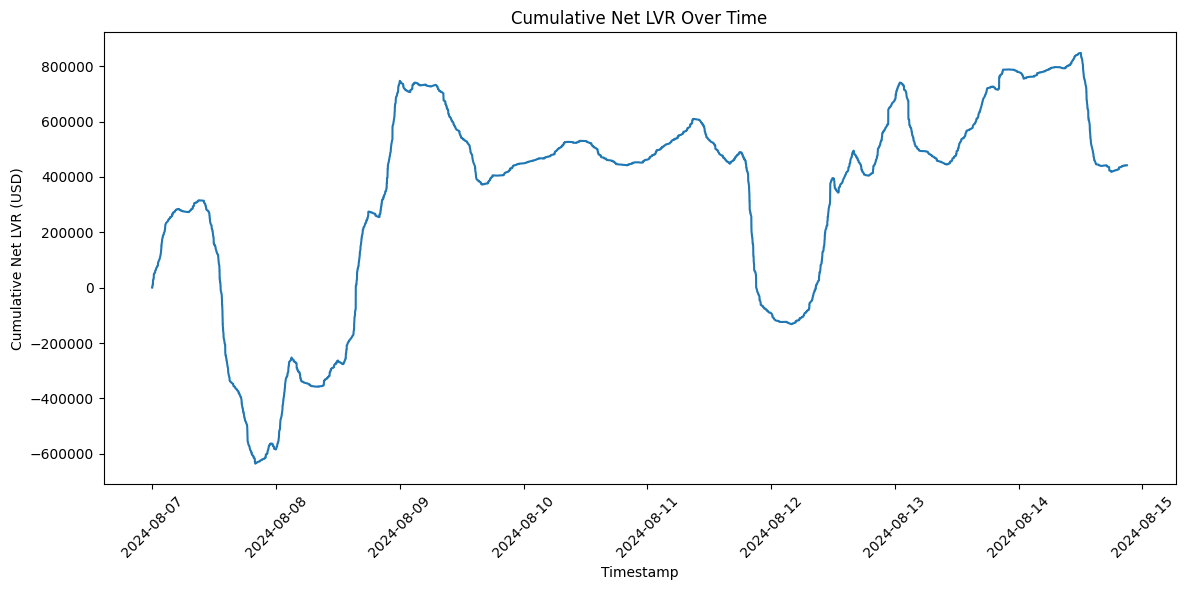


Total Net LVR (TAM) for the last 7 days: $442422.48
Total Volume: $623816243.26
LVR as percentage of Volume: 0.07%


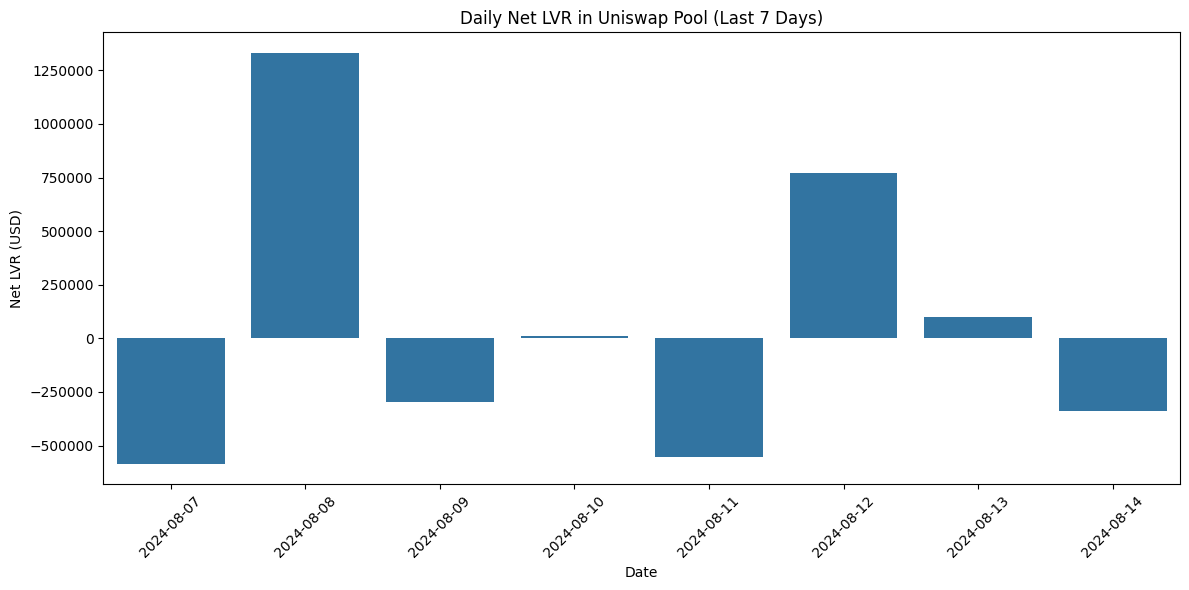

Average Daily Net LVR: $55302.81
Median Daily Net LVR: $-142385.96
Max Daily Net LVR: $1331579.26
Min Daily Net LVR: $-584245.31

Top 10 Net LVR events:
                block_timestamp   eth_amount  uniswap_price  coinbase_price  \
60073 2024-08-12 22:42:59+00:00  1211.126684        2679.39         2723.00   
21464 2024-08-08 22:34:59+00:00   424.447024        2572.56         2683.59   
18707 2024-08-08 15:27:59+00:00   289.295306        2436.12         2587.11   
55740 2024-08-12 11:27:47+00:00   575.015059        2614.92         2686.02   
18713 2024-08-08 15:28:47+00:00   192.461011        2436.12         2587.11   
20974 2024-08-08 21:38:23+00:00   210.367396        2578.26         2708.50   
69831 2024-08-13 20:13:11+00:00   589.492505        2685.04         2730.80   
21776 2024-08-08 23:02:11+00:00   354.940133        2615.42         2666.82   
54704 2024-08-12 09:17:59+00:00   238.444008        2572.47         2642.26   
20901 2024-08-08 21:27:47+00:00   125.600200        2578.

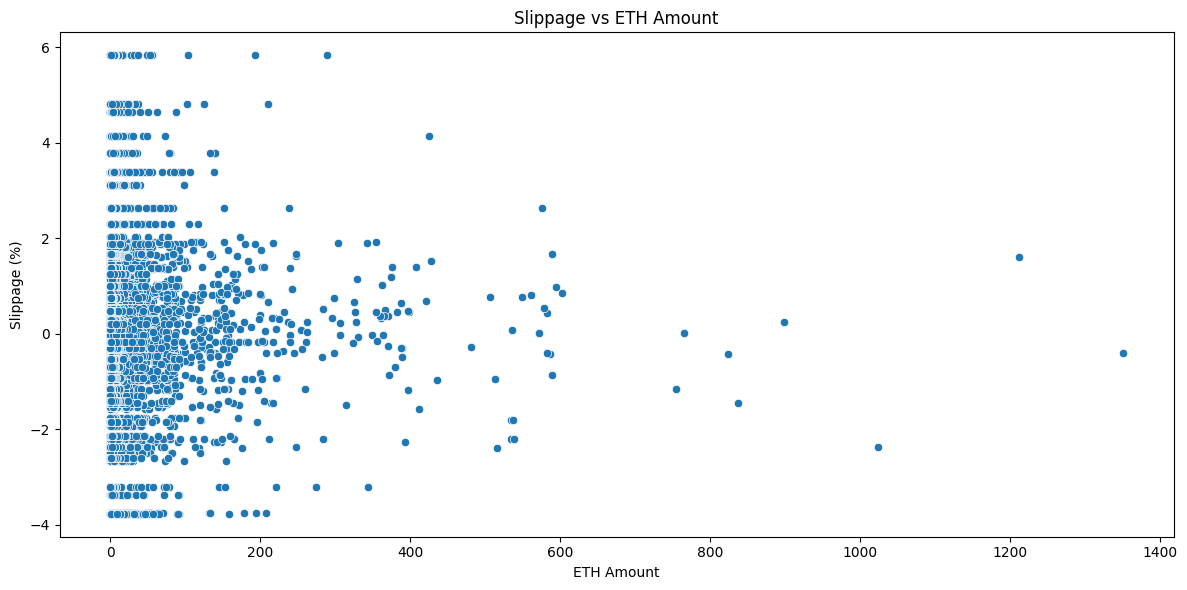

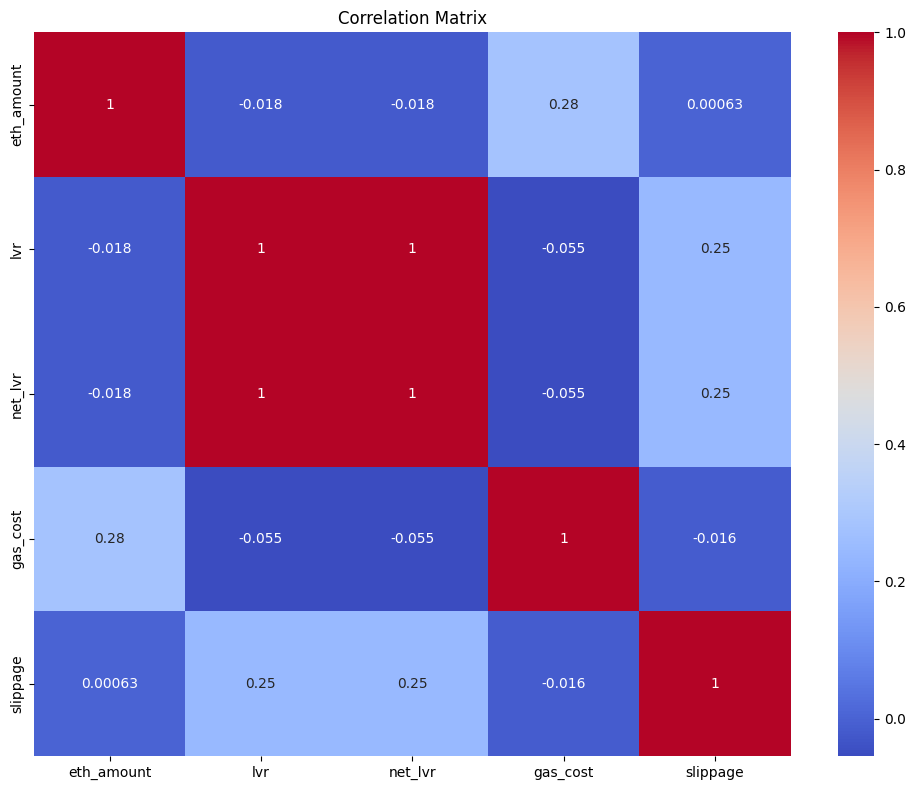

In [ ]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from flipside import Flipside
import seaborn as sns
import pytz
import numpy as np

flipside = Flipside("65fcaea7-e348-4d7f-abc0-c8943077ccd0", "https://api-v2.flipsidecrypto.xyz")

seven_days_ago = (datetime.now(pytz.UTC) - timedelta(days=7)).strftime('%Y-%m-%d')

sql = f"""
SELECT
    s.block_timestamp,
    s.amount_in,
    s.amount_out,
    s.token_in,
    s.token_out,
    s.amount_in_usd,
    s.amount_out_usd,
    p_in.price AS price_in,
    p_out.price AS price_out,
    p_in.decimals AS decimals_in,
    p_out.decimals AS decimals_out,
    t.gas_price,
    t.gas_used
FROM
    ethereum.defi.ez_dex_swaps s
LEFT JOIN
    ethereum.price.ez_prices_hourly p_in
ON
    s.token_in = p_in.token_address
    AND DATE_TRUNC('hour', s.block_timestamp) = p_in.hour
LEFT JOIN
    ethereum.price.ez_prices_hourly p_out
ON
    s.token_out = p_out.token_address
    AND DATE_TRUNC('hour', s.block_timestamp) = p_out.hour
LEFT JOIN
    ethereum.core.fact_transactions t
ON
    s.tx_hash = t.tx_hash
WHERE
    s.contract_address = '0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b'
    AND s.block_timestamp >= '{seven_days_ago}'
ORDER BY
    s.block_timestamp ASC
"""

uniswap_swaps = flipside.query(sql)
df_swaps = pd.DataFrame(uniswap_swaps.records)

df_swaps['block_timestamp'] = pd.to_datetime(df_swaps['block_timestamp'], utc=True)

df_swaps = df_swaps.dropna(subset=['block_timestamp', 'amount_in', 'amount_out', 'price_in', 'price_out', 'decimals_in', 'decimals_out'])

def get_coinbase_prices(start_time, end_time, product_id='ETH-USD'):
    url = f'https://api.pro.coinbase.com/products/{product_id}/candles'
    params = {
        'start': start_time.isoformat(),
        'end': end_time.isoformat(),
        'granularity': 3600
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        candles = response.json()
        return pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    return pd.DataFrame()

start_time = df_swaps['block_timestamp'].min()
end_time = df_swaps['block_timestamp'].max()
coinbase_prices = get_coinbase_prices(start_time, end_time)
coinbase_prices['timestamp'] = pd.to_datetime(coinbase_prices['timestamp'], unit='s', utc=True)
coinbase_prices.set_index('timestamp', inplace=True)
coinbase_prices['close'] = coinbase_prices['close'].astype(float).round(2)

def calculate_lvr(row):
    if row['token_in'] == 'WETH':
        eth_amount = float(row['amount_in']) * (10 ** (18 - row['decimals_in']))
        uniswap_eth_price = float(row['price_in'])
    else:
        eth_amount = float(row['amount_out']) * (10 ** (18 - row['decimals_out']))
        uniswap_eth_price = float(row['price_out'])

    try:
        coinbase_eth_price = float(coinbase_prices.loc[coinbase_prices.index.asof(row['block_timestamp']), 'close'])
        price_diff = coinbase_eth_price - uniswap_eth_price
        lvr = eth_amount * price_diff
        gas_cost = (float(row['gas_price']) * float(row['gas_used'])) / 1e18 * coinbase_eth_price
        net_lvr = lvr - gas_cost if lvr > 0 else lvr
    except KeyError:
        coinbase_eth_price = None
        lvr = None
        net_lvr = None
        gas_cost = None

    return pd.Series({
        'lvr': lvr,
        'net_lvr': net_lvr,
        'eth_amount': eth_amount,
        'uniswap_price': uniswap_eth_price,
        'coinbase_price': coinbase_eth_price,
        'gas_cost': gas_cost
    })

df_swaps = df_swaps.join(df_swaps.apply(calculate_lvr, axis=1))

df_swaps = df_swaps[(df_swaps['uniswap_price'] >= 1000) & (df_swaps['lvr'].notnull()) & (df_swaps['eth_amount'] > 0)]

print("\nSummary Statistics:")
print(df_swaps[['lvr', 'net_lvr', 'eth_amount', 'uniswap_price', 'coinbase_price', 'gas_cost']].head(5))

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
df_swaps['lvr'].hist(ax=axes[0, 0], bins=50)
axes[0, 0].set_title('LVR Distribution (USD)')
df_swaps['net_lvr'].hist(ax=axes[0, 1], bins=50)
axes[0, 1].set_title('Net LVR Distribution (USD)')
df_swaps['eth_amount'].hist(ax=axes[1, 0], bins=50)
axes[1, 0].set_title('ETH Amount Distribution')
sns.scatterplot(data=df_swaps, x='uniswap_price', y='coinbase_price', ax=axes[1, 1])
axes[1, 1].set_title('Uniswap vs Coinbase Price')
axes[1, 1].set_aspect('equal')
df_swaps['gas_cost'].hist(ax=axes[2, 0], bins=50)
axes[2, 0].set_title('Gas Cost Distribution (USD)')
sns.scatterplot(data=df_swaps, x='eth_amount', y='net_lvr', ax=axes[2, 1])
axes[2, 1].set_title('ETH Amount vs Net LVR')
plt.tight_layout()
plt.show()

df_swaps = df_swaps.sort_values('block_timestamp')
df_swaps['cumulative_net_lvr'] = df_swaps['net_lvr'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_swaps['block_timestamp'], df_swaps['cumulative_net_lvr'])
plt.title('Cumulative Net LVR Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Net LVR (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_net_lvr = df_swaps['net_lvr'].sum()
total_volume = df_swaps['eth_amount'].sum() * df_swaps['coinbase_price'].mean()

print(f"\nTotal Net LVR (TAM) for the last 7 days: ${total_net_lvr:.2f}")
print(f"Total Volume: ${total_volume:.2f}")
print(f"LVR as percentage of Volume: {(total_net_lvr / total_volume * 100):.2f}%")

df_swaps['date'] = df_swaps['block_timestamp'].dt.date
daily_net_lvr = df_swaps.groupby('date')['net_lvr'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='date', y='net_lvr', data=daily_net_lvr)
plt.title('Daily Net LVR in Uniswap Pool (Last 7 Days)')
plt.xlabel('Date')
plt.ylabel('Net LVR (USD)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

print(f"Average Daily Net LVR: ${daily_net_lvr['net_lvr'].mean():.2f}")
print(f"Median Daily Net LVR: ${daily_net_lvr['net_lvr'].median():.2f}")
print(f"Max Daily Net LVR: ${daily_net_lvr['net_lvr'].max():.2f}")
print(f"Min Daily Net LVR: ${daily_net_lvr['net_lvr'].min():.2f}")

print("\nTop 10 Net LVR events:")
print(df_swaps.nlargest(10, 'net_lvr')[['block_timestamp', 'eth_amount', 'uniswap_price', 'coinbase_price', 'lvr', 'net_lvr', 'gas_cost']])

print("\nBottom 10 Net LVR events:")
print(df_swaps.nsmallest(10, 'net_lvr')[['block_timestamp', 'eth_amount', 'uniswap_price', 'coinbase_price', 'lvr', 'net_lvr', 'gas_cost']])

profitable_trades = df_swaps[df_swaps['net_lvr'] > 0]
print(f"\nNumber of profitable trades: {len(profitable_trades)}")
print(f"Percentage of profitable trades: {len(profitable_trades) / len(df_swaps) * 100:.2f}%")
print(f"Total profit from profitable trades: ${profitable_trades['net_lvr'].sum():.2f}")

df_swaps['slippage'] = (df_swaps['coinbase_price'] - df_swaps['uniswap_price']) / df_swaps['coinbase_price'] * 100
plt.figure(figsize=(12, 6))
sns.scatterplot(x='eth_amount', y='slippage', data=df_swaps)
plt.title('Slippage vs ETH Amount')
plt.xlabel('ETH Amount')
plt.ylabel('Slippage (%)')
plt.tight_layout()
plt.show()

correlation_matrix = df_swaps[['eth_amount', 'lvr', 'net_lvr', 'gas_cost', 'slippage']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()